# Test the FERC analysis module

Whew! this new analysis module is a bit much, so I created this notebook to explain what's going on, known quirks, etc.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries
import logging
import sys
import os
import pathlib
import random

# 3rd party libraries
import geopandas as gpd
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import sqlalchemy as sa
import re

# Local libraries
import pudl
from pudl.analysis.clean_up_ferc1 import *

# Enable viewing of logging outputs
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [3]:
# Establish connection to pudl database
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
pudl_out = pudl.output.pudltabl.PudlTabl(
    pudl_engine=pudl_engine,
    freq='AS'
)

ferc_engine = sa.create_engine(pudl_settings['ferc1_db'])

In [4]:
# Recreate the transform process
small_plants_raw = pd.read_sql("f1_gnrt_plant", ferc_engine)
small_plants = pudl_out.plants_small_ferc1()

# Here we create a fake raw dfs dictionary with just the small plants df to run it through
# Zane's existing transform feature.
fake_dict = {'plants_small_ferc1': small_plants_raw}
new_dict = {}
small_plants_dict = pudl.transform.ferc1.plants_small(fake_dict, new_dict)
small_plants_out = small_plants_dict['plants_small_ferc1']

# drop rows with no plant name because we can't use that
small_plants_out = small_plants_out.dropna(subset=['plant_name_ferc1'])

/Users/aesharpe/miniconda3/envs/pudl-dev/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
# Helper function

def get_rand_group(groups):
    random_set = random.choice(list(groups.groups.keys()))
    return groups.get_group(random_set)

In [6]:
com_cols = ['record_id', 'utility_id_ferc1', 'report_year', 'plant_name_ferc1', 
            'row_type', 'construction_year', 'capacity_mw', 'net_generation_mwh']

## Test Module

In [7]:
# Run full cleaning
#%%time
test_full = clean_small_gens(small_plants_out)

UsageError: Line magic function `%%time` not found.


In [10]:
# Run individual steps
#%%time
test1 = remove_bad_rows_sg(small_plants_out, show_removed=True)
test2 = label_row_type_sg(test1)
test3 = improve_plant_type_sg(test2) ## COME UP WITH A WAY TO CHECK FUEL TYPE OVER TIME MAYBE BY PLANT ID?
test4 = extract_ferc_license_sg(test3)
test5 = associate_notes_with_values_sg(test4)

Removing rows where an entire utility has reported NA in key columns
Removing rows with three or more dashes for plant name
Removing rows with NA for plant name

 REMOVED NAN VALUES: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234 entries, 0 to 20243
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   construction_year    0 non-null      float64
 1   net_generation_mwh   0 non-null      float64
 2   total_cost_of_plant  0 non-null      float64
 3   capex_per_mw         0 non-null      float64
 4   opex_total           0 non-null      float64
 5   opex_fuel            0 non-null      float64
 6   opex_maintenance     0 non-null      float64
 7   fuel_cost_per_mmbtu  0 non-null      float64
dtypes: float64(8)
memory usage: 16.5 KB
None 


 REMOVED DASH NAMES: 

 plant_name_ferc1                   
------------------                     25
-------------------                    16
-----           

### Take a closer look at each of the steps...

#### LABELING ROW TYPE

This step identifies the "type" of row as either a total, note, header, or NA (regular row). 
Pay attention to the `row_type` column.

In [85]:
# Look at random, relevant chunks of the data by utility and year
# Re-run this cell to refresh and see a new utility/year group

util_groups = test2.groupby(['utility_id_ferc1', 'report_year'])
get_rand_group(util_groups)[com_cols]

,record_id,utility_id_ferc1,report_year,plant_name_ferc1,row_type,construction_year,capacity_mw,net_generation_mwh
4820,f1_gnrt_plant_1999_12_95_0_1,95,1999,gas turbine,header,NaN,0.0,NaN
4821,f1_gnrt_plant_1999_12_95_0_2,95,1999,williston,NaN,1953.0,7.8,75700.0


#### EXTRACTING PLANT TYPE FROM HEADERS AND PLANT NAME

This step extracts the plant type from the header rows as well as the plant name (when it's not a header) and puts it in the `plant_type_2` column (for comparison with Zane's `plant_type` column).

Known issues: 
* 161, 1994
* 29, 2000
* 170, 1996
* 44, 2003

In [87]:
print('\nCOMPARE PLANT TYPE FROM HEADERS WITH PLANT TYPE:')
same_plt_type = test5[
    test5['plant_type'] == test5['plant_type_2']]
diff_plt_type = test5[
    (test5['plant_type_2'].notna()) & 
    (test5['plant_type'].notna()) & 
    (test5['plant_type_2']!=test5['plant_type'])]
new_plt_type = test5[
    (test5['plant_type'].isna()) & 
    (test5['plant_type_2'].notna())]
print(
    f'''
    same plant type: {len(same_plt_type)}
    diff plant type: {len(diff_plt_type)} 
    new plant type: {len(new_plt_type)}''')

print("\nShow records where plant type differs")
display(diff_plt_type[com_cols + ['plant_type', 'plant_type_2']])


COMPARE PLANT TYPE FROM HEADERS WITH PLANT TYPE:

    same plant type: 4547
    diff plant type: 497 
    new plant type: 8787

Show records where plant type differs


,record_id,utility_id_ferc1,report_year,plant_name_ferc1,row_type,construction_year,capacity_mw,net_generation_mwh,plant_type,plant_type_2
8189,f1_gnrt_plant_2004_12_25_0_2,25,2004,st. albans,NaN,1950.0,2.6,43.0,internal_combustion,diesel_turbine
8222,f1_gnrt_plant_2004_12_44_0_10,44,2004,* connors creek,NaN,1971.0,5.5,-21.0,internal_combustion,steam_heat
8223,f1_gnrt_plant_2004_12_44_0_11,44,2004,*harbor beach,NaN,1967.0,4.0,-45.0,internal_combustion,steam_heat
8224,f1_gnrt_plant_2004_12_44_0_12,44,2004,*st. clair,NaN,1970.0,5.5,-654.0,internal_combustion,steam_heat
8263,f1_gnrt_plant_2004_12_61_0_13,61,2004,vergennes station # 9,NaN,1963.0,4.0,606.0,internal_combustion,diesel_turbine
...,...,...,...,...,...,...,...,...,...,...
16713,f1_gnrt_plant_2016_12_281_0_5,281,2016,total diesel,total,NaN,10.0,-182490.0,internal_combustion,diesel_turbine
16762,f1_gnrt_plant_2016_12_73_0_14,73,2016,twin branch,NaN,2016.0,2.6,1388.0,hydro,solar_pv
16871,f1_gnrt_plant_2016_12_115_0_10,115,2016,auburn gas turbine,NaN,2000.0,7.3,245.0,gas_turbine,internal_combustion
16968,f1_gnrt_plant_2016_12_161_1_24,161,2016,uc santa barbara fuel cell,NaN,2012.0,0.2,1648683.0,fuel_cell,solar_pv


In [95]:
# Look at random, relevant chunks of the data by utility and year
# Re-run this cell to refresh and see a new utility/year group

util_groups = test3.groupby(['utility_id_ferc1', 'report_year'])
util_groups_with_row_types = (
    util_groups.filter(lambda x: x['row_type'].notna().any())
    .groupby(['utility_id_ferc1', 'report_year']))
get_rand_group(util_groups_with_row_types)[com_cols + ['plant_type', 'plant_type_2']]

,record_id,utility_id_ferc1,report_year,plant_name_ferc1,row_type,construction_year,capacity_mw,net_generation_mwh,plant_type,plant_type_2
3055,f1_gnrt_plant_1997_12_69_0_1,69,1997,diesel plants:,header,NaN,NaN,NaN,NaN,diesel_turbine
3056,f1_gnrt_plant_1997_12_69_0_3,69,1997,centerville,NaN,1963.0,6.00,-38000.0,NaN,diesel_turbine
3057,f1_gnrt_plant_1997_12_69_0_4,69,1997,ames,NaN,1960.0,2.00,2500.0,NaN,diesel_turbine
3058,f1_gnrt_plant_1997_12_69_0_5,69,1997,marshalltown,NaN,1941.0,5.00,-142020.0,NaN,diesel_turbine
3059,f1_gnrt_plant_1997_12_69_0_7,69,1997,total diesel....................................,total,NaN,13.00,-177520.0,NaN,diesel_turbine
3060,f1_gnrt_plant_1997_12_69_0_13,69,1997,hydro plants:,header,NaN,NaN,NaN,NaN,hydro
3061,f1_gnrt_plant_1997_12_69_0_15,69,1997,anamosa,NaN,1990.0,0.24,1050240.0,NaN,hydro
3062,f1_gnrt_plant_1997_12_69_0_16,69,1997,maquoketa,NaN,1924.0,1.36,5465000.0,NaN,hydro
3063,f1_gnrt_plant_1997_12_69_0_17,69,1997,iowa falls,NaN,1926.0,0.65,1548453.0,NaN,hydro
3064,f1_gnrt_plant_1997_12_69_0_19,69,1997,total hydro.....................................,total,NaN,2.25,8063693.0,NaN,hydro


#### EXTRACTING FERC LICENSES AND ASSOCIATING NOTES WITH PROPER ROWS

This step takes ferc licenses from the name and from notes and associates both the ferc license and the note with the relevant row when possible. Pay attention to the `ferc_license`, `ferc_license_manual`, and `notes` columns.

Known issues: 
* 193, 2001
* 61, 2002

In [11]:
manual_lic = test5[test5['ferc_license_manual'].notna()]
prog_lic_of_manual = manual_lic[manual_lic['ferc_license'].notna()]
print(f'{round(len(prog_lic_of_manual) / len(manual_lic) * 100)}% of FERC licenses that were manually mapped are caught by the program')
print('Sample of manual licenses not grabbed by program')
display(manual_lic[manual_lic['ferc_license'].isna()].sample(2))

same_lic = prog_lic_of_manual[prog_lic_of_manual['ferc_license_manual']==prog_lic_of_manual['ferc_license']]
print(f'\n{round(len(prog_lic_of_manual) / len(same_lic) * 100)}% of manual licenses are the same as the programatically mapped ones!')
print('Cases where manual license differs from programatic license excluding NA values')
display(prog_lic_of_manual[prog_lic_of_manual['ferc_license_manual']!=prog_lic_of_manual['ferc_license']])

prog_lic = test5[test5['ferc_license'].notna()]
print(f'\nThere are {len(manual_lic)} manually mapped licenses vs. {len(prog_lic)} programatically mapped licenses')

90% of FERC licenses that were manually mapped are caught by the program
Sample of manual licenses not grabbed by program


,utility_id_ferc1,report_year,plant_name_ferc1,row_type,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,...,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_clean,plant_type,ferc_license_manual,record_id,plant_type_2,ferc_license,notes
14415,159,2013,hydro-neal shoals,note,NaN,0.0,0.0,NaN,NaN,NaN,...,NaN,,NaN,neal shoals,hydro,2315,f1_gnrt_plant_2013_12_159_0_1,NaN,<NA>,<NA>
10104,159,2006,hydro-neal shoals,NaN,1905.0,4.4,10.0,20105000.0,5723448.0,285.0,...,320119.0,,NaN,neal shoals,hydro,2315,f1_gnrt_plant_2006_12_159_0_1,hydro,<NA>,<NA>



100% of manual licenses are the same as the programatically mapped ones!
Cases where manual license differs from programatic license excluding NA values


,utility_id_ferc1,report_year,plant_name_ferc1,row_type,construction_year,capacity_mw,peak_demand_mw,net_generation_mwh,total_cost_of_plant,capex_per_mw,...,opex_maintenance,fuel_type,fuel_cost_per_mmbtu,plant_name_clean,plant_type,ferc_license_manual,record_id,plant_type_2,ferc_license,notes
9776,151,2006,rochester station #160 (note 3),NaN,1916.0,0.34,0.0,NaN,254356.0,748106.0,...,NaN,hydro,NaN,rochester station #160,hydro,2596,f1_gnrt_plant_2006_12_151_0_5,NaN,160,NaN
10472,151,2007,rochester station #160 (note 3),NaN,1916.0,0.34,0.0,NaN,NaN,NaN,...,NaN,hydro,NaN,rochester station #160,hydro,2596,f1_gnrt_plant_2007_12_151_0_5,NaN,160,NaN



There are 1842 manually mapped licenses vs. 4754 programatically mapped licenses


In [12]:
# Look at random, relevant chunks of the data by utility and year
# Re-run this cell to refresh and see a new utility/year group

util_groups = test5.groupby(['utility_id_ferc1', 'report_year'])
util_groups_with_licenses = (
    util_groups.filter(lambda x: x['ferc_license'].notna().any())
    .groupby(['utility_id_ferc1', 'report_year']))
util_groups_with_notes = (
    util_groups.filter(lambda x: x['notes'].notna().any())
    .groupby(['utility_id_ferc1', 'report_year']))

# Show chunks with ferc licenses
print("HIGHLIGHT FERC LICENSES")
display(get_rand_group(util_groups_with_licenses)[com_cols + ['ferc_license', 'ferc_license_manual', 'notes']])

# Show chunks with notes
print("HIGHLIGHT NOTES")
display(get_rand_group(util_groups_with_notes)[com_cols + ['ferc_license', 'ferc_license_manual', 'notes']])

HIGHLIGHT FERC LICENSES


,record_id,utility_id_ferc1,report_year,plant_name_ferc1,row_type,construction_year,capacity_mw,net_generation_mwh,ferc_license,ferc_license_manual,notes
6998,f1_gnrt_plant_2002_12_146_0_1,146,2002,hydro:,header,NaN,0.0,NaN,<NA>,<NA>,<NA>
6999,f1_gnrt_plant_2002_12_146_0_2,146,2002,ayers island #2456,NaN,1925.0,8.4,34023765.0,2456,<NA>,<NA>
7000,f1_gnrt_plant_2002_12_146_0_3,146,2002,canaan #7528,NaN,1928.0,1.1,7639424.0,7528,<NA>,<NA>
7001,f1_gnrt_plant_2002_12_146_0_4,146,2002,eastman falls #2457,NaN,1912.0,6.4,20397480.0,2457,<NA>,<NA>
7002,f1_gnrt_plant_2002_12_146_0_5,146,2002,gorham #2288,NaN,1909.0,2.2,8721180.0,2288,<NA>,<NA>
7003,f1_gnrt_plant_2002_12_146_0_6,146,2002,hooksett #1913,NaN,1927.0,1.6,7130880.0,1913,<NA>,<NA>
7004,f1_gnrt_plant_2002_12_146_0_7,146,2002,jackman,NaN,1925.0,3.2,8281700.0,<NA>,<NA>,<NA>
7005,f1_gnrt_plant_2002_12_146_0_11,146,2002,internal combustion:,header,NaN,0.0,NaN,<NA>,<NA>,<NA>
7006,f1_gnrt_plant_2002_12_146_0_12,146,2002,swans falls diesel,NaN,1948.0,3.0,NaN,<NA>,<NA>,<NA>


HIGHLIGHT NOTES


,record_id,utility_id_ferc1,report_year,plant_name_ferc1,row_type,construction_year,capacity_mw,net_generation_mwh,ferc_license,ferc_license_manual,notes
16112,f1_gnrt_plant_2015_12_115_0_1,115,2015,hydro,header,NaN,0.00,NaN,<NA>,<NA>,<NA>
16113,f1_gnrt_plant_2015_12_115_0_2,115,2015,rainbow falls (b),NaN,1926.0,2.64,NaN,2835,2835,(b) project #2835
16114,f1_gnrt_plant_2015_12_115_0_3,115,2015,cadyville (a),NaN,1921.0,5.53,21670.0,2738,2738,(a) project #2738
16115,f1_gnrt_plant_2015_12_115_0_4,115,2015,keuka (c),NaN,1928.0,0.00,NaN,2852,2852,(c) project #2852
16116,f1_gnrt_plant_2015_12_115_0_5,115,2015,"mill ""c"" (a)",NaN,1922.0,6.05,19214.0,2738,2738,(a) project #2738
16117,f1_gnrt_plant_2015_12_115_0_8,115,2015,internal combustion,header,NaN,0.00,NaN,<NA>,<NA>,<NA>
16118,f1_gnrt_plant_2015_12_115_0_9,115,2015,harris lake,NaN,1967.0,4.25,52.0,<NA>,<NA>,NaN
16119,f1_gnrt_plant_2015_12_115_0_10,115,2015,auburn gas turbine,NaN,2000.0,7.25,380.0,<NA>,<NA>,NaN
16120,f1_gnrt_plant_2015_12_115_0_12,115,2015,(a) project #2738,note,NaN,0.00,NaN,2738,<NA>,<NA>
16121,f1_gnrt_plant_2015_12_115_0_13,115,2015,(b) project #2835,note,NaN,0.00,NaN,2835,<NA>,<NA>


# Visuals

<AxesSubplot:ylabel='plant_type_2'>

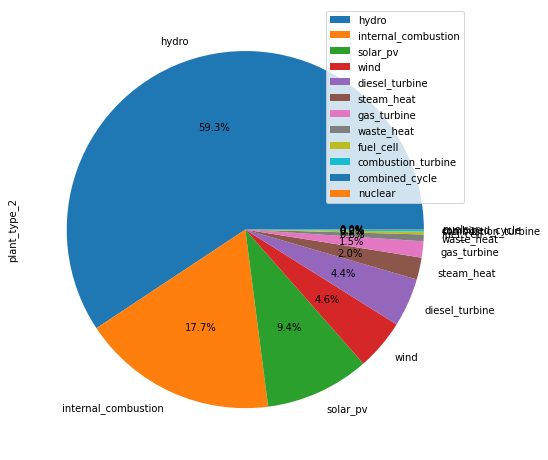

In [98]:
TEST.plant_type_2.value_counts().plot(
    kind='pie', figsize=(8,16), legend=True, autopct='%1.1f%%',)